In [1]:
import tushare as ts
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from statsmodels.tsa.stattools import adfuller
from datetime import datetime
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


# 设置中文显示（防止图表中文乱码）
plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows系统可用
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
plt.rcParams['font.family'] = 'sans-serif'



In [2]:
ts.set_token('48214906a56d6318dd8a7315f934ef249f9a033ccf82bd04a65e6ded')  # 替换为你的Token
pro = ts.pro_api()


In [3]:
# 定义获取指数数据的函数
def get_index_data(ts_code, start_date, end_date):
    df = pro.index_daily(
        ts_code=ts_code,
        start_date=start_date,
        end_date=end_date
    )
    df['trade_date'] = pd.to_datetime(df['trade_date'], format='%Y%m%d')
    df.set_index('trade_date', inplace=True)
    df.sort_index(inplace=True)
    return df[['close']]

# 定义时间范围
today = datetime.now().strftime('%Y%m%d')
start_date = '20150101'
end_date = today

# 获取各指数的收盘价数据
hs300 = get_index_data('000300.SH', start_date, end_date)
zz1000 = get_index_data('000852.SH', start_date, end_date)
zz500 = get_index_data('000905.SH', start_date, end_date)
shci = get_index_data('000001.SH', start_date, end_date)

# 组合数据到同一个DataFrame
combined = pd.DataFrame({
    'HS300': hs300['close'],
    'ZZ1000': zz1000['close'],
    'ZZ500': zz500['close'],
    'SHCI': shci['close']
})

# 填补可能的缺失值（使用前向填充和后向填充）
for col in ['HS300', 'ZZ1000', 'ZZ500', 'SHCI']:
    combined[col] = combined[col].ffill().bfill()

# 打印获取的数据（部分输出）
print("数据获取完成，展示部分数据:")
print(combined.tail())  # 显示数据的前几行
print("\n数据基本信息:")
print(combined.info())   # 显示数据的基本信息
print("\n数据描述统计:")
print(combined.describe())  # 显示数据的统计摘要


数据获取完成，展示部分数据:
                HS300     ZZ1000      ZZ500       SHCI
trade_date                                            
2025-10-27  4716.0186  7495.3831  7379.3941  3996.9445
2025-10-28  4691.9730  7479.2210  7341.0304  3988.2239
2025-10-29  4747.8378  7569.1170  7480.9666  4016.3310
2025-10-30  4709.9110  7485.0848  7385.7109  3986.9008
2025-10-31  4640.6676  7506.6746  7331.0031  3954.7900

数据基本信息:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2631 entries, 2015-01-05 to 2025-10-31
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HS300   2631 non-null   float64
 1   ZZ1000  2631 non-null   float64
 2   ZZ500   2631 non-null   float64
 3   SHCI    2631 non-null   float64
dtypes: float64(4)
memory usage: 102.8 KB
None

数据描述统计:
             HS300        ZZ1000         ZZ500         SHCI
count  2631.000000   2631.000000   2631.000000  2631.000000
mean   3932.255662   6840.963338   6059.040818  3219.702372
std     5

In [4]:
# 计算比价关系
combined['ZZ1000_VS_HS300'] = combined['ZZ1000'] / combined['HS300']
combined['ZZ500_VS_HS300'] = combined['ZZ500'] / combined['HS300']

# 计算30日移动平均
combined['ZZ1000_VS_HS300_MA'] = combined['ZZ1000_VS_HS300'].rolling(30).mean()
combined['ZZ500_VS_HS300_MA'] = combined['ZZ500_VS_HS300'].rolling(30).mean()

# 打印计算结果（部分输出）
print("\n比价关系及30日移动平均，展示部分数据:")
print(combined[['ZZ1000_VS_HS300', 'ZZ500_VS_HS300', 
                'ZZ1000_VS_HS300_MA', 'ZZ500_VS_HS300_MA']].tail())



比价关系及30日移动平均，展示部分数据:
            ZZ1000_VS_HS300  ZZ500_VS_HS300  ZZ1000_VS_HS300_MA  \
trade_date                                                        
2025-10-27         1.589346        1.564751            1.625675   
2025-10-28         1.594046        1.564593            1.624261   
2025-10-29         1.594224        1.575658            1.623107   
2025-10-30         1.589220        1.568121            1.621866   
2025-10-31         1.617585        1.579730            1.621550   

            ZZ500_VS_HS300_MA  
trade_date                     
2025-10-27           1.579868  
2025-10-28           1.579851  
2025-10-29           1.580310  
2025-10-30           1.580601  
2025-10-31           1.581055  


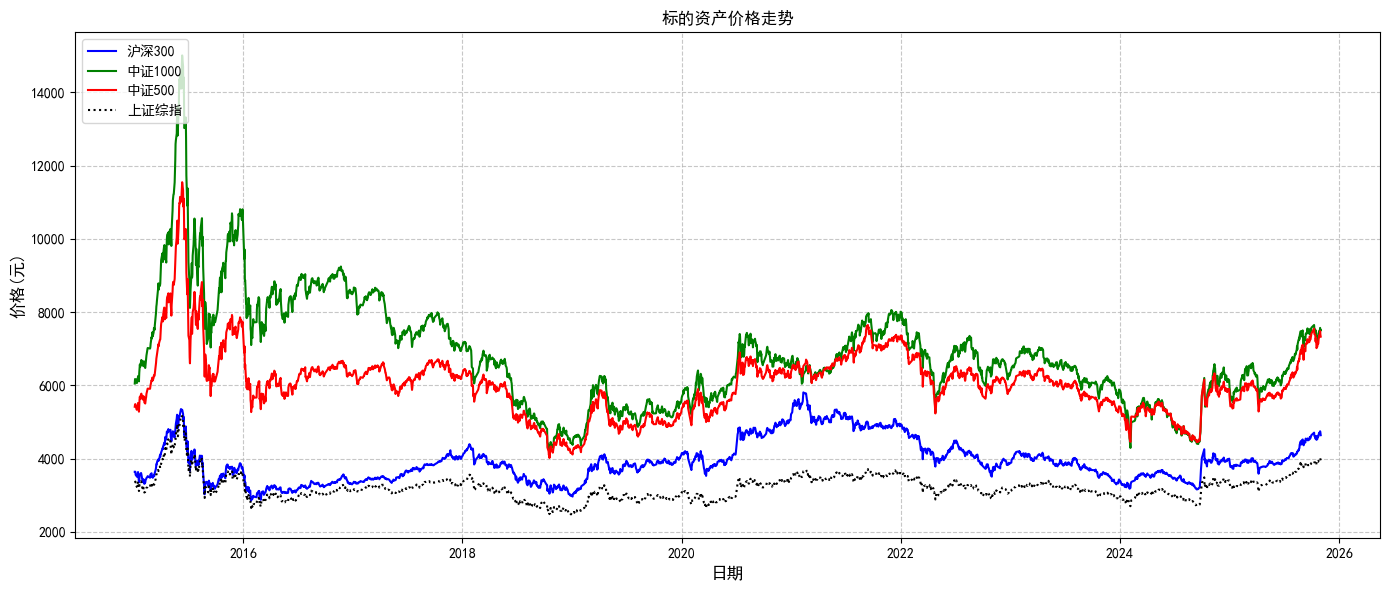

In [5]:
# 绘制标的资产价格走势图
plt.figure(figsize=(14, 6))
plt.title('标的资产价格走势')
plt.plot(combined['HS300'], label='沪深300', color='blue')
plt.plot(combined['ZZ1000'], label='中证1000', color='green')
plt.plot(combined['ZZ500'], label='中证500', color='red')
plt.plot(combined['SHCI'], label='上证综指', color='black', linestyle=':')

plt.xlabel('日期', fontsize=12)
plt.ylabel('价格(元)', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()


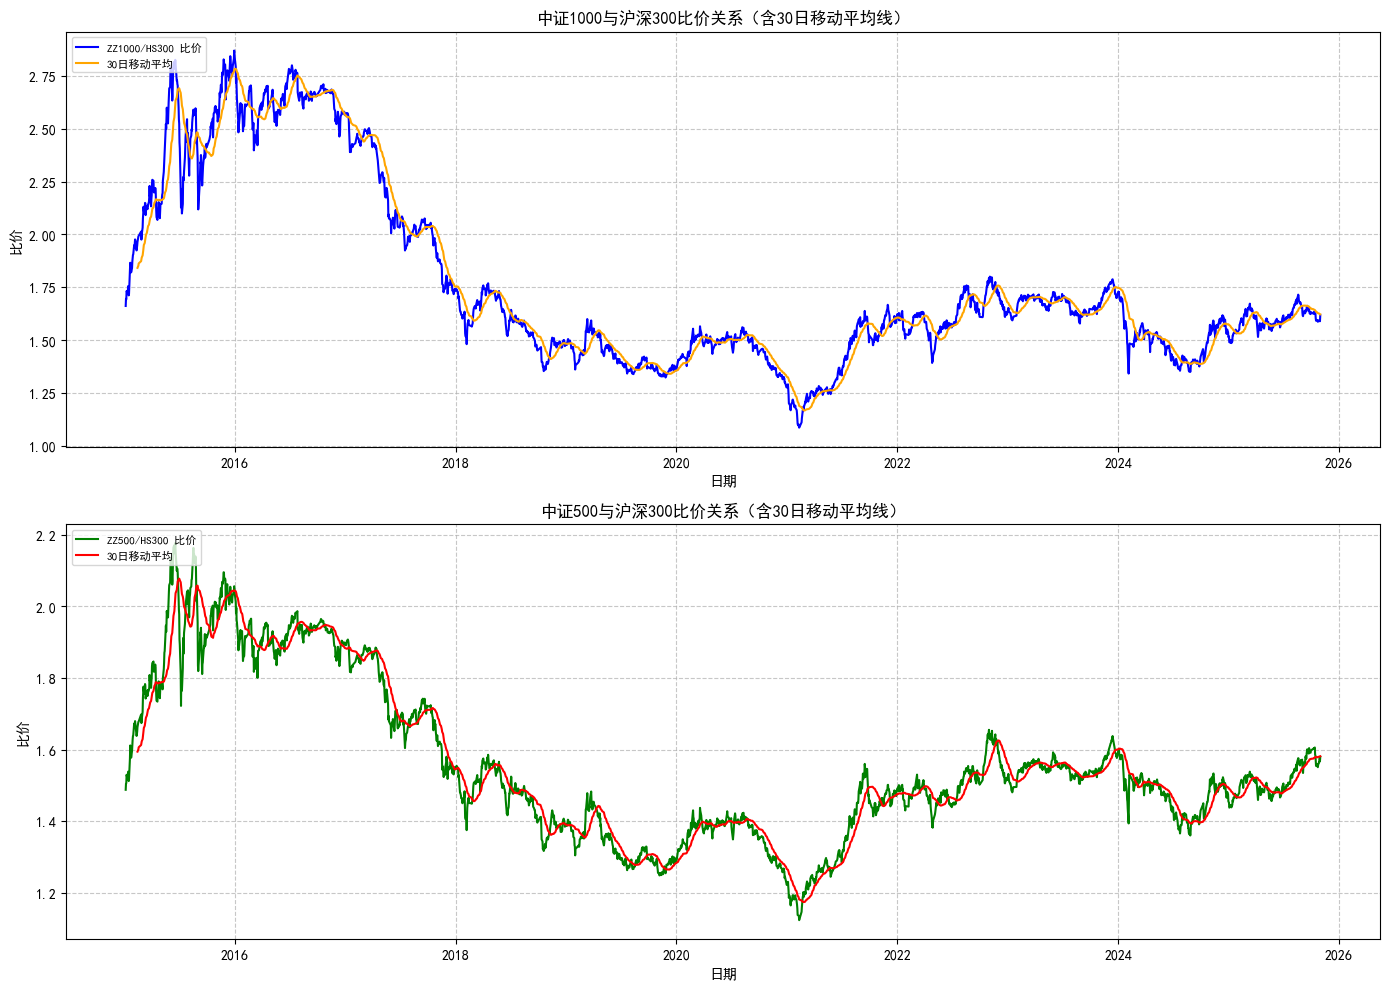

In [6]:
# 创建一个包含两个子图的图表
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
plt.subplots_adjust(hspace=0.4)  # 调整子图之间的间距

# 子图1：沪深300与中证1000的比价关系
ax1.set_title('中证1000与沪深300比价关系（含30日移动平均线）', fontsize=12)
ax1.plot(combined['ZZ1000_VS_HS300'], label='ZZ1000/HS300 比价', color='blue')
ax1.plot(combined['ZZ1000_VS_HS300_MA'], label='30日移动平均', color='orange', linewidth=1.5)
ax1.set_xlabel('日期', fontsize=10)
ax1.set_ylabel('比价', fontsize=10)
ax1.grid(True, which='both', linestyle='--', alpha=0.7)
ax1.legend(loc='upper left', fontsize=8)

# 子图2：沪深300与中证500的比价关系
ax2.set_title('中证500与沪深300比价关系（含30日移动平均线）', fontsize=12)
ax2.plot(combined['ZZ500_VS_HS300'], label='ZZ500/HS300 比价', color='green')
ax2.plot(combined['ZZ500_VS_HS300_MA'], label='30日移动平均', color='red', linewidth=1.5)
ax2.set_xlabel('日期', fontsize=10)
ax2.set_ylabel('比价', fontsize=10)
ax2.grid(True, which='both', linestyle='--', alpha=0.7)
ax2.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()


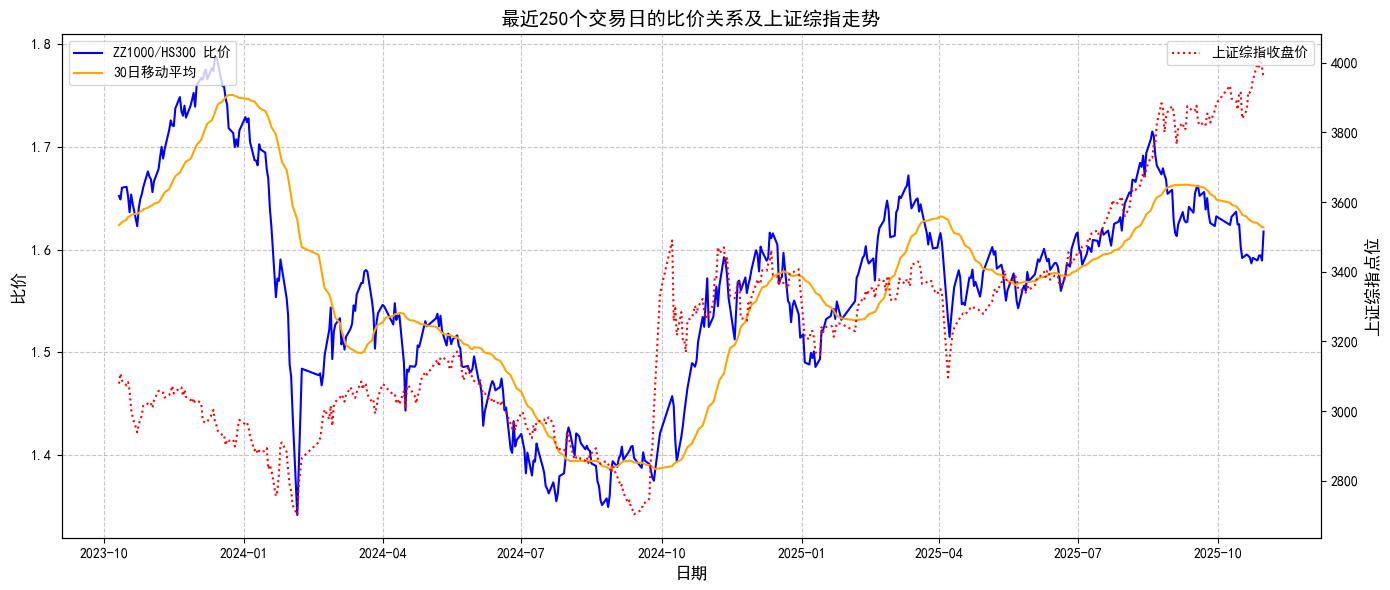

In [7]:
# 截取最近250个交易日的数据
combined_recent = combined.iloc[-500:]

# 创建主图表
fig, ax1 = plt.subplots(figsize=(14, 6))
plt.title('最近250个交易日的比价关系及上证综指走势', fontsize=14)

# 主坐标轴：绘制沪深300与中证1000的比价关系
ax1.plot(combined_recent['ZZ1000_VS_HS300'], 
         label='ZZ1000/HS300 比价', 
         color='blue', 
         linewidth=1.5)
ax1.plot(combined_recent['ZZ1000_VS_HS300_MA'], 
         label='30日移动平均', 
         color='orange', 
         linewidth=1.5)
ax1.set_xlabel('日期', fontsize=12)
ax1.set_ylabel('比价', fontsize=12)
ax1.grid(True, which='both', linestyle='--', alpha=0.7)
ax1.legend(loc='upper left', fontsize=10)

# 次坐标轴：绘制上证综指收盘价
ax2 = ax1.twinx()
ax2.plot(combined_recent['SHCI'], 
         label='上证综指收盘价', 
         color='red', 
         linewidth=1.5,
         linestyle=':')
ax2.set_ylabel('上证综指点位', fontsize=12)
ax2.legend(loc='upper right', fontsize=10)

# 调整布局，避免重叠
plt.tight_layout()
plt.show()


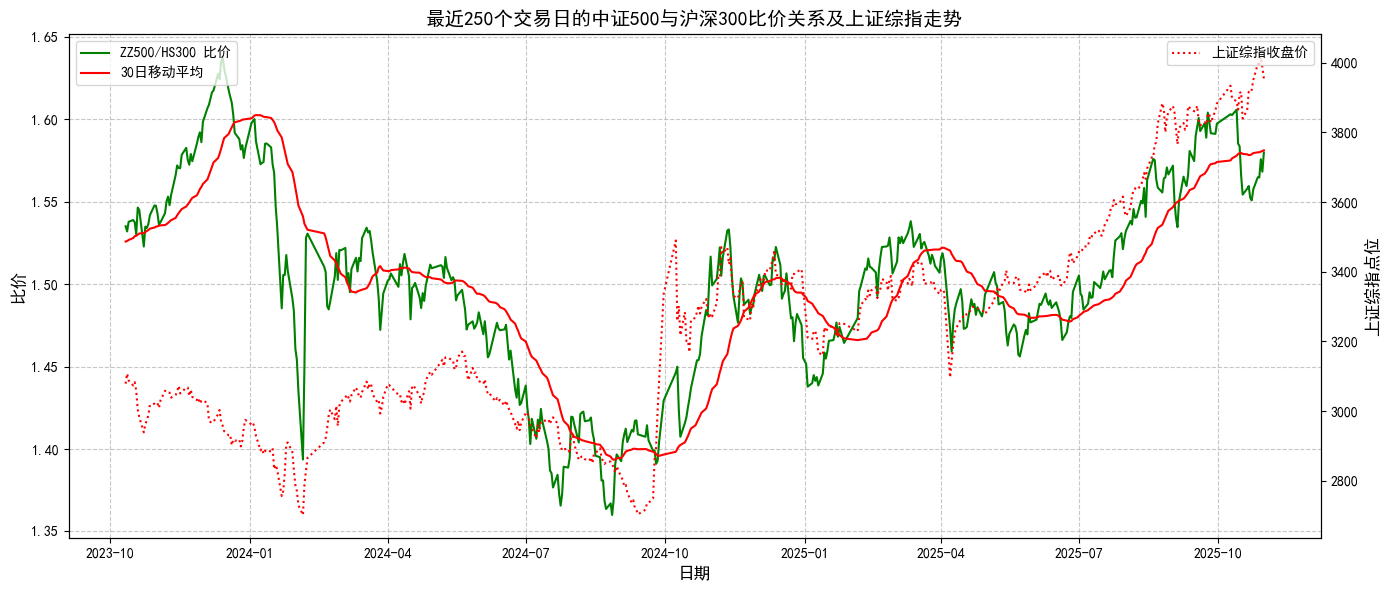

In [8]:
# 创建主图表
fig, ax1 = plt.subplots(figsize=(14, 6))
plt.title('最近250个交易日的中证500与沪深300比价关系及上证综指走势', fontsize=14)

# 主坐标轴：绘制沪深300与中证500的比价关系
ax1.plot(combined_recent['ZZ500_VS_HS300'], 
         label='ZZ500/HS300 比价', 
         color='green', 
         linewidth=1.5)
ax1.plot(combined_recent['ZZ500_VS_HS300_MA'], 
         label='30日移动平均', 
         color='red', 
         linewidth=1.5)
ax1.set_xlabel('日期', fontsize=12)
ax1.set_ylabel('比价', fontsize=12)
ax1.grid(True, which='both', linestyle='--', alpha=0.7)
ax1.legend(loc='upper left', fontsize=10)

# 次坐标轴：绘制上证综指收盘价
ax2 = ax1.twinx()
ax2.plot(combined_recent['SHCI'], 
         label='上证综指收盘价', 
         color='red', 
         linewidth=1.5,
         linestyle=':')
ax2.set_ylabel('上证综指点位', fontsize=12)
ax2.legend(loc='upper right', fontsize=10)

# 调整布局，避免重叠
plt.tight_layout()
plt.show()


In [9]:
# 保存标的资产价格走势图
plt.figure(figsize=(14, 6))
plt.title('标的资产价格走势')
plt.plot(combined['HS300'], label='沪深300', color='blue')
plt.plot(combined['ZZ1000'], label='中证1000', color='green')
plt.plot(combined['ZZ500'], label='中证500', color='red')
plt.plot(combined['SHCI'], label='上证综指', color='black', linestyle=':')

plt.xlabel('日期', fontsize=12)
plt.ylabel('价格(元)', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.savefig('assets_price_trend.pdf', dpi=300, bbox_inches='tight')
plt.close()

# 保存比价关系走势分开图表
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
plt.subplots_adjust(hspace=0.4)

ax1.set_title('中证1000与沪深300比价关系（含30日移动平均线）', fontsize=12)
ax1.plot(combined['ZZ1000_VS_HS300'], label='ZZ1000/HS300 比价', color='blue')
ax1.plot(combined['ZZ1000_VS_HS300_MA'], label='30日移动平均', color='orange', linewidth=1.5)
ax1.set_xlabel('日期', fontsize=10)
ax1.set_ylabel('比价', fontsize=10)
ax1.grid(True, which='both', linestyle='--', alpha=0.7)
ax1.legend(loc='upper left', fontsize=8)

ax2.set_title('沪深300与中证500比价关系（含30日移动平均线）', fontsize=12)
ax2.plot(combined['ZZ500_VS_HS300'], label='HS300/ZZ500 比价', color='green')
ax2.plot(combined['ZZ500_VS_HS300_MA'], label='30日移动平均', color='red', linewidth=1.5)
ax2.set_xlabel('日期', fontsize=10)
ax2.set_ylabel('比价', fontsize=10)
ax2.grid(True, which='both', linestyle='--', alpha=0.7)
ax2.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig('price_ratio_trend.pdf', dpi=300, bbox_inches='tight')
plt.close()

# 保存最近250个交易日的沪深300与中证1000的比价关系与上证综指走势
fig, ax1 = plt.subplots(figsize=(14, 6))
plt.title('最近250个交易日的中证1000与沪深300比价关系及上证综指走势', fontsize=14)

ax1.plot(combined_recent['ZZ1000_VS_HS300'], 
         label='ZZ1000/HS300 比价', 
         color='blue', 
         linewidth=1.5)
ax1.plot(combined_recent['ZZ1000_VS_HS300_MA'], 
         label='30日移动平均', 
         color='orange', 
         linewidth=1.5)
ax1.set_xlabel('日期', fontsize=12)
ax1.set_ylabel('比价', fontsize=12)
ax1.grid(True, which='both', linestyle='--', alpha=0.7)
ax1.legend(loc='upper left', fontsize=10)

# 次坐标轴：绘制上证综指收盘价
ax2 = ax1.twinx()
ax2.plot(combined_recent['SHCI'], 
         label='上证综指收盘价', 
         color='red', 
         linewidth=1.5,
         linestyle=':')
ax2.set_ylabel('上证综指点位', fontsize=12)
ax2.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig('recent_250_days_hsz1000_vs_shci.pdf', dpi=300, bbox_inches='tight')
plt.close()

# 保存最近250个交易日的沪深300与中证500的比价关系与上证综指走势
fig, ax1 = plt.subplots(figsize=(14, 6))
plt.title('最近250个交易日的中证500与沪深300比价关系及上证综指走势', fontsize=14)

ax1.plot(combined_recent['ZZ500_VS_HS300'], 
         label='ZZ500/HS300 比价', 
         color='green', 
         linewidth=1.5)
ax1.plot(combined_recent['ZZ500_VS_HS300_MA'], 
         label='30日移动平均', 
         color='orange', 
         linewidth=1.5)
ax1.set_xlabel('日期', fontsize=12)
ax1.set_ylabel('比价', fontsize=12)
ax1.grid(True, which='both', linestyle='--', alpha=0.7)
ax1.legend(loc='upper left', fontsize=10)

# 次坐标轴：绘制上证综指收盘价
ax2 = ax1.twinx()
ax2.plot(combined_recent['SHCI'], 
         label='上证综指收盘价', 
         color='red', 
         linewidth=1.5,
         linestyle=':')
ax2.set_ylabel('上证综指点位', fontsize=12)
ax2.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig('recent_250_days_hsz500_vs_shci.pdf', dpi=300, bbox_inches='tight')
plt.close()


### 行业ETF比价

#### 第一部分：获取数据

In [10]:
# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 定义获取数据函数（增强版）
def get_etf_data(ts_code, start_date, end_date, asset_type='ETF', max_retries=3):
    """获取ETF或指数数据"""
    for attempt in range(max_retries):
        try:
            if asset_type == 'ETF':
                df = pro.fund_daily(ts_code=ts_code, 
                                  start_date=start_date,
                                  end_date=end_date)
            else:  # 指数
                df = pro.index_daily(ts_code=ts_code,
                                   start_date=start_date,
                                   end_date=end_date)
            
            df['trade_date'] = pd.to_datetime(df['trade_date'], format='%Y%m%d')
            df.set_index('trade_date', inplace=True)
            df.sort_index(inplace=True)
            return df[['close']]
        
        except Exception as e:
            if attempt == max_retries - 1:
                raise Exception(f"获取{ts_code}数据失败: {str(e)}")
            continue



# 设置时间范围
today = datetime.now().strftime('%Y%m%d')
start_date = '20211101'
end_date = today

# 标的列表（新增中证红利指数）
targets = {
    'CSI_ALL': ('000985.CSI', '中证全指', 'INDEX'),
    'CHIP_ETF': ('159995.SZ', '芯片ETF', 'ETF'),
    'SECURITY_ETF': ('512880.SH', '证券ETF', 'ETF'),
    'MED_ETF': ('512010.SH', '医药ETF', 'ETF'),
    'PV_ETF': ('515790.SH', '光伏ETF', 'ETF'),
    'SOFTWARE_ETF': ('515230.SH', '软件ETF', 'ETF'),
    'REALSTATE_ETF': ('512200.SH', '房地产ETF', 'ETF'),
    'WINE_ETF': ('512690.SH', '酒ETF', 'ETF'),
    'TRAVEL_ETF': ('562510.SH', '旅游ETF', 'ETF'),
    'MILITARY_ETF': ('512660.SH', '军工ETF', 'ETF'),
    'MEDIA_ETF': ('512980.SH', '传媒ETF', 'ETF'),
    'DI_DIVIDEND': ('512890.SH', '低波ETF', 'ETF'),
    'COAL_ETF': ('515220.SH', '煤炭ETF', 'ETF')   
}

# 获取数据
data_dict = {}
print("开始获取数据...")
for key, (code, name, atype) in targets.items():
    print(f"正在获取 {name}({code}) 数据...")
    try:
        data_dict[key] = get_etf_data(code, start_date, end_date, asset_type=atype)
        if data_dict[key] is None:
            print(f"警告: 未能获取 {name}({code}) 数据")
    except Exception as e:
        print(f"警告: 获取 {name}({code}) 数据失败: {str(e)}")
        data_dict[key] = None

# 合并数据
combined = pd.concat(
    {key: data_dict[key]['close'] for key in targets.keys() if data_dict[key] is not None},
    axis=1
).ffill().bfill()

# 数据质量报告
print("\n=== 数据质量报告 ===")
print("1. 各标的起始日期:")
for col in combined.columns:
    print(f"{targets[col][1]:<10}: {combined[col].first_valid_index()}")

print("\n2. 留存数据列:", combined.columns.tolist())
combined.tail(10)


开始获取数据...
正在获取 中证全指(000985.CSI) 数据...
正在获取 芯片ETF(159995.SZ) 数据...
正在获取 证券ETF(512880.SH) 数据...
正在获取 医药ETF(512010.SH) 数据...
正在获取 光伏ETF(515790.SH) 数据...
正在获取 软件ETF(515230.SH) 数据...
正在获取 房地产ETF(512200.SH) 数据...
正在获取 酒ETF(512690.SH) 数据...
正在获取 旅游ETF(562510.SH) 数据...
正在获取 军工ETF(512660.SH) 数据...
正在获取 传媒ETF(512980.SH) 数据...
正在获取 低波ETF(512890.SH) 数据...
正在获取 煤炭ETF(515220.SH) 数据...

=== 数据质量报告 ===
1. 各标的起始日期:
中证全指      : 2021-11-01 00:00:00
芯片ETF     : 2021-11-01 00:00:00
证券ETF     : 2021-11-01 00:00:00
医药ETF     : 2021-11-01 00:00:00
光伏ETF     : 2021-11-01 00:00:00
软件ETF     : 2021-11-01 00:00:00
房地产ETF    : 2021-11-01 00:00:00
酒ETF      : 2021-11-01 00:00:00
旅游ETF     : 2021-11-01 00:00:00
军工ETF     : 2021-11-01 00:00:00
传媒ETF     : 2021-11-01 00:00:00
低波ETF     : 2021-11-01 00:00:00
煤炭ETF     : 2021-11-01 00:00:00

2. 留存数据列: ['CSI_ALL', 'CHIP_ETF', 'SECURITY_ETF', 'MED_ETF', 'PV_ETF', 'SOFTWARE_ETF', 'REALSTATE_ETF', 'WINE_ETF', 'TRAVEL_ETF', 'MILITARY_ETF', 'MEDIA_ETF', 'DI_DIVIDEND', 'COAL_E

,CSI_ALL,CHIP_ETF,SECURITY_ETF,MED_ETF,PV_ETF,SOFTWARE_ETF,REALSTATE_ETF,WINE_ETF,TRAVEL_ETF,MILITARY_ETF,MEDIA_ETF,DI_DIVIDEND,COAL_ETF
trade_date,,,,,,,,,,,,,
2025-10-20,5697.1596,1.720,1.235,0.414,0.913,0.906,1.606,0.591,0.733,1.180,0.957,1.187,1.218
2025-10-21,5788.8328,1.773,1.246,0.419,0.925,0.917,1.643,0.592,0.735,1.196,0.968,1.190,1.203
2025-10-22,5764.9285,1.769,1.234,0.416,0.909,0.906,1.655,0.589,0.732,1.182,0.964,1.199,1.181
2025-10-23,5772.7822,1.758,1.245,0.416,0.917,0.919,1.636,0.593,0.737,1.178,0.970,1.206,1.210
2025-10-24,5842.5729,1.843,1.257,0.417,0.933,0.930,1.619,0.582,0.728,1.208,0.975,1.197,1.188
2025-10-27,5913.0717,1.894,1.272,0.423,0.941,0.937,1.619,0.582,0.728,1.222,0.975,1.198,1.197
2025-10-28,5893.1369,1.877,1.264,0.416,0.933,0.947,1.610,0.582,0.728,1.236,0.971,1.198,1.184
2025-10-29,5961.1939,1.881,1.292,0.420,1.010,0.958,1.623,0.579,0.733,1.243,0.988,1.187,1.200
2025-10-30,5898.9039,1.839,1.267,0.409,1.007,0.941,1.598,0.579,0.734,1.219,0.972,1.190,1.194


In [11]:
# 第二部分：比价关系计算
print("计算比价关系中...")

# 定义需要计算比价的标的（排除中证全指本身）
ratio_targets = [k for k in targets.keys() if k not in ['CSI_ALL']]

# 计算所有标的相对于中证全指的比价
for target in ratio_targets:
    ratio_col = f"{target}_VS_CSI_ALL"
    ma_col = f"{ratio_col}_MA30"
    
    combined[ratio_col] = combined[target] / combined['CSI_ALL']
    combined[ma_col] = combined[ratio_col].rolling(30).mean()

# 打印最新比价值
print("\n=== 最新比价值 ===")
latest_ratios = combined[[col for col in combined.columns 
                         if '_VS_CSI_ALL' in col and 'MA30' not in col]].iloc[-1]
print(latest_ratios.sort_values(ascending=False).round(4))

# 显示计算结果
combined[[col for col in combined.columns if '_VS_CSI_ALL' in col]].tail(3)


计算比价关系中...

=== 最新比价值 ===
CHIP_ETF_VS_CSI_ALL         0.0003
REALSTATE_ETF_VS_CSI_ALL    0.0003
SECURITY_ETF_VS_CSI_ALL     0.0002
MILITARY_ETF_VS_CSI_ALL     0.0002
DI_DIVIDEND_VS_CSI_ALL      0.0002
COAL_ETF_VS_CSI_ALL         0.0002
PV_ETF_VS_CSI_ALL           0.0002
MEDIA_ETF_VS_CSI_ALL        0.0002
SOFTWARE_ETF_VS_CSI_ALL     0.0002
TRAVEL_ETF_VS_CSI_ALL       0.0001
WINE_ETF_VS_CSI_ALL         0.0001
MED_ETF_VS_CSI_ALL          0.0001
Name: 2025-10-31 00:00:00, dtype: float64


,CHIP_ETF_VS_CSI_ALL,CHIP_ETF_VS_CSI_ALL_MA30,SECURITY_ETF_VS_CSI_ALL,SECURITY_ETF_VS_CSI_ALL_MA30,MED_ETF_VS_CSI_ALL,MED_ETF_VS_CSI_ALL_MA30,PV_ETF_VS_CSI_ALL,PV_ETF_VS_CSI_ALL_MA30,SOFTWARE_ETF_VS_CSI_ALL,SOFTWARE_ETF_VS_CSI_ALL_MA30,...,TRAVEL_ETF_VS_CSI_ALL,TRAVEL_ETF_VS_CSI_ALL_MA30,MILITARY_ETF_VS_CSI_ALL,MILITARY_ETF_VS_CSI_ALL_MA30,MEDIA_ETF_VS_CSI_ALL,MEDIA_ETF_VS_CSI_ALL_MA30,DI_DIVIDEND_VS_CSI_ALL,DI_DIVIDEND_VS_CSI_ALL_MA30,COAL_ETF_VS_CSI_ALL,COAL_ETF_VS_CSI_ALL_MA30
trade_date,,,,,,,,,,,,,,,,,,,,,
2025-10-29,0.000316,0.000306,0.000217,0.000216,0.000070,0.000074,0.000169,0.000159,0.000161,0.000164,...,0.000123,0.000126,0.000209,0.000208,0.000166,0.000175,0.000199,0.000202,0.000201,0.000194
2025-10-30,0.000312,0.000307,0.000215,0.000216,0.000069,0.000074,0.000171,0.000160,0.000160,0.000163,...,0.000124,0.000126,0.000207,0.000208,0.000165,0.000174,0.000202,0.000202,0.000202,0.000194
2025-10-31,0.000301,0.000308,0.000214,0.000215,0.000070,0.000074,0.000169,0.000160,0.000165,0.000163,...,0.000126,0.000126,0.000205,0.000208,0.000169,0.000174,0.000203,0.000202,0.000201,0.000195


NameError: name 'os' is not defined

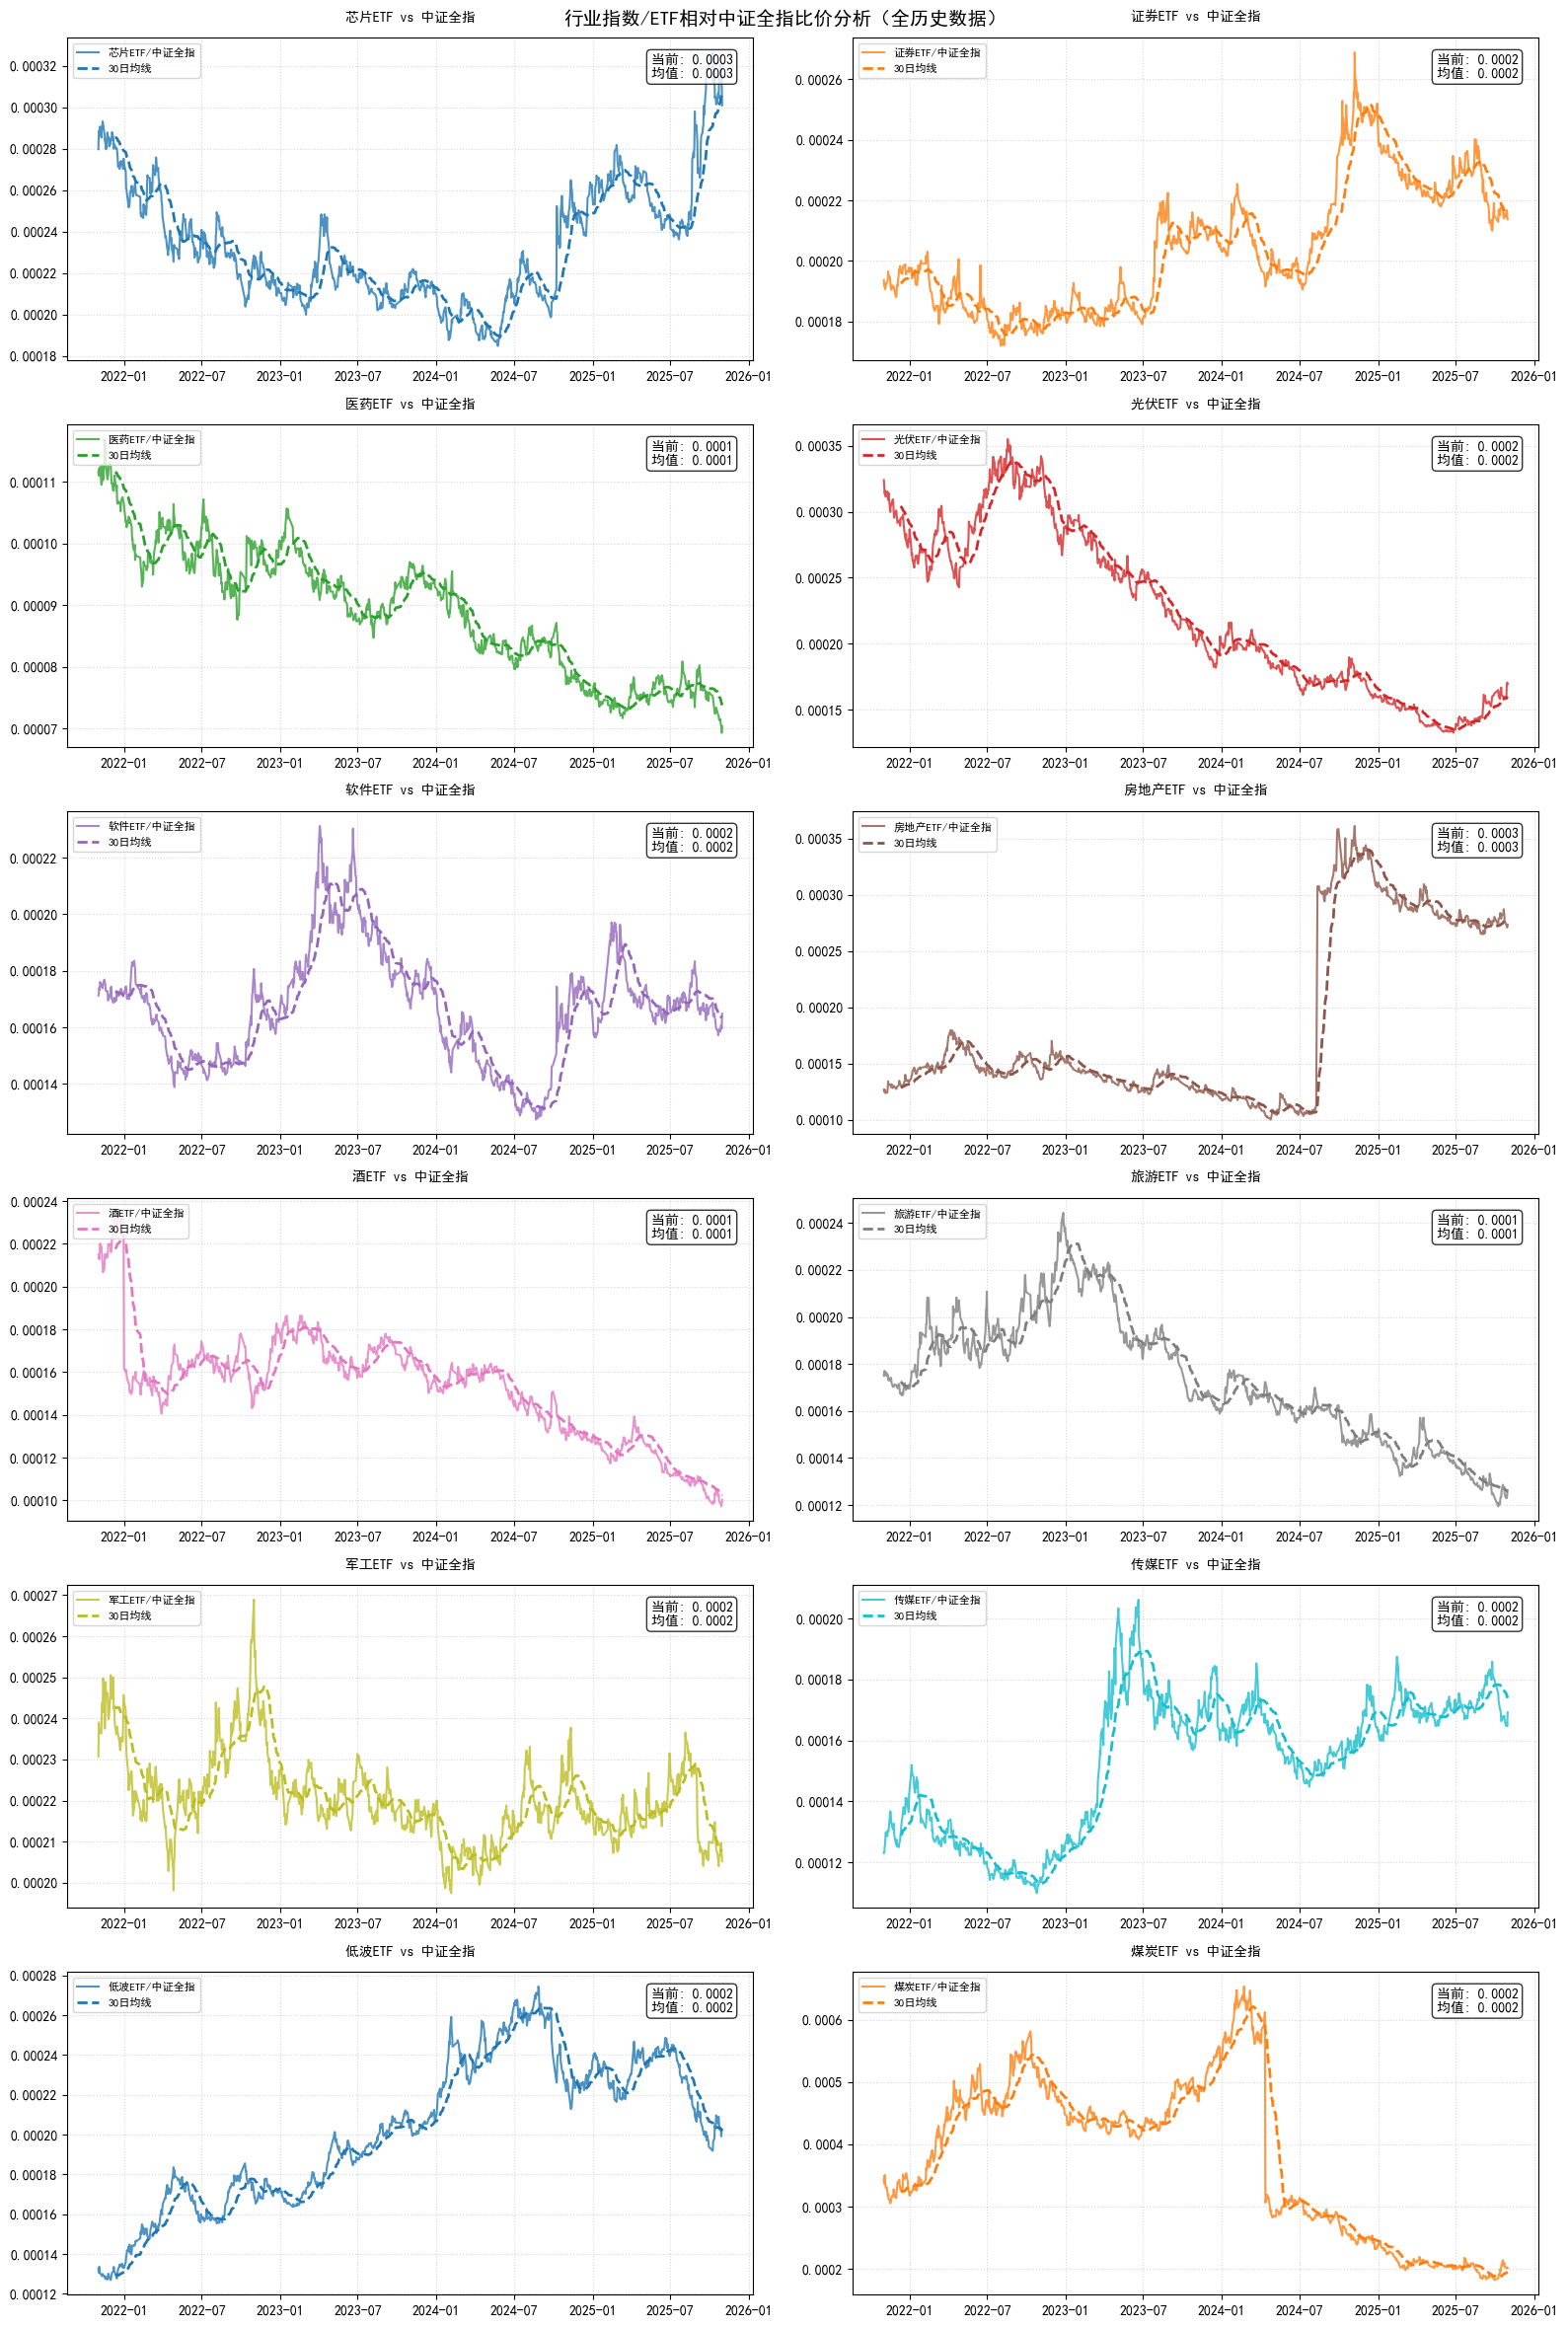

In [12]:
# 第三部分：完整历史比价图表
import matplotlib.pyplot as plt

# 创建图表
fig, axes = plt.subplots(6, 2, figsize=(16, 24))  # 调整子图布局
plt.subplots_adjust(hspace=0.8, wspace=0.25)  # 增加子图间距

# 为每个标的创建图表
for i, (target, ax) in enumerate(zip(ratio_targets, axes.flatten())):
    name = targets[target][1]
    ratio_col = f"{target}_VS_CSI_ALL"
    
    # 绘制比价曲线
    ax.plot(combined[ratio_col], 
            label=f'{name}/中证全指',
            color=f'C{i % 12}',  # 避免颜色重复
            alpha=0.8,
            linewidth=1.5)
    
    # 绘制移动平均线
    ax.plot(combined[f'{ratio_col}_MA30'],
            label='30日均线',
            color=f'C{i % 12}',
            linestyle='--',
            linewidth=2)
    
    # 添加标注
    last_val = combined[ratio_col].iloc[-1]
    ma_val = combined[f'{ratio_col}_MA30'].iloc[-1]
    ax.annotate(f'当前: {last_val:.4f}\n均值: {ma_val:.4f}',
                xy=(0.97, 0.95),
                xycoords='axes fraction',
                ha='right', va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 美化图表
    ax.set_title(f'{name} vs 中证全指', pad=12, fontsize=10)
    ax.grid(True, linestyle=':', alpha=0.5)
    ax.legend(loc='upper left', fontsize=8)

# 添加总标题
fig.suptitle('行业指数/ETF相对中证全指比价分析（全历史数据）', 
             y=0.98, fontsize=14, fontweight='bold')
plt.tight_layout()

# 获取源数据所在目录（假设combined数据来自某个CSV文件）
source_dir = os.path.dirname(os.path.abspath('your_source_data.csv'))  # 请替换为实际源数据路径
output_pdf = os.path.join(source_dir, '行业ETF_Report.pdf')

# 保存为PDF
plt.savefig(output_pdf, bbox_inches='tight')
print(f'图表已保存为PDF: {output_pdf}')

plt.show()
plt.close(fig)

In [ ]:
# 第四部分：最近250个交易日比价图表（带PDF输出功能）
import matplotlib.pyplot as plt
import os
from matplotlib.backends.backend_pdf import PdfPages

# 获取最近250个交易日数据
recent_250 = combined.iloc[-250:]

# 创建图表
fig, axes = plt.subplots(6, 2, figsize=(16, 24))
plt.subplots_adjust(hspace=0.8, wspace=0.25)

# 为每个标的创建图表
for i, (target, ax) in enumerate(zip(
    ratio_targets,
    axes.flatten()
)):
    name = targets[target][1]
    ratio_col = f"{target}_VS_CSI_ALL"
    ma_col = f"{ratio_col}_MA30"
    
    # 绘制比价曲线
    ax.plot(recent_250[ratio_col], 
            label=f'{name}/中证全指',
            color=f'C{i % 12}',  # 确保颜色不重复
            alpha=0.8,
            linewidth=1.5)
    
    # 绘制移动平均线
    ax.plot(recent_250[ma_col],
            label='30日均线',
            color=f'C{i % 12}',
            linestyle='--',
            linewidth=2)
    
    # 添加标注
    current_ratio = recent_250[ratio_col].iloc[-1]
    current_ma = recent_250[ma_col].iloc[-1]
    ax.annotate(f'当前: {current_ratio:.4f}\n30日均值: {current_ma:.4f}',
                xy=(0.97, 0.95),
                xycoords='axes fraction',
                ha='right', va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 添加比率变化标注
    pct_change = (recent_250[ratio_col].iloc[-1] / recent_250[ratio_col].iloc[0] - 1) * 100
    ax.annotate(f'{pct_change:+.1f}%',
                xy=(0.03, 0.95),
                xycoords='axes fraction',
                ha='left', va='top',
                color='red' if pct_change < 0 else 'green',
                fontweight='bold')
    
    # 美化图表
    ax.set_title(f'{name} vs 中证全指 (近250交易日)', pad=10, fontsize=10)
    ax.grid(True, linestyle=':', alpha=0.5)
    ax.legend(loc='upper left', fontsize=8)

# 添加总标题
fig.suptitle('行业指数相对中证全指比价分析（最近250个交易日）', 
             y=0.98, fontsize=14, fontweight='bold')

# 框架调整
plt.tight_layout()

# ========== 新增PDF输出功能 ==========
# 获取源数据所在目录（假设combined数据来自某个CSV文件）
source_dir = os.path.dirname(os.path.abspath('your_source_data.csv'))  # 请替换为实际源数据路径
output_pdf = os.path.join(source_dir, '行业ETF_250Days_Report.pdf')

# 保存为PDF
plt.savefig(output_pdf, bbox_inches='tight')
print(f'图表已保存为PDF: {output_pdf}')

plt.show()
plt.close(fig)  # 关闭图形释放内存
